**A lifetime of temperatures**

In [1]:
import  numpy as np
import  pandas as pd
import  matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

In [2]:
ind = pd.read_csv("indianapolis.csv", index_col = 2)
mi = pd.read_csv("miami.csv", index_col = 2)
dc = pd.read_csv("dc.csv", index_col = 2)
pitt = pd.read_csv("pittsburgh.csv", index_col=2)
chic = pd.read_csv("chicago.csv", index_col = 2)
cities = [ind, mi, dc, pitt, chic]

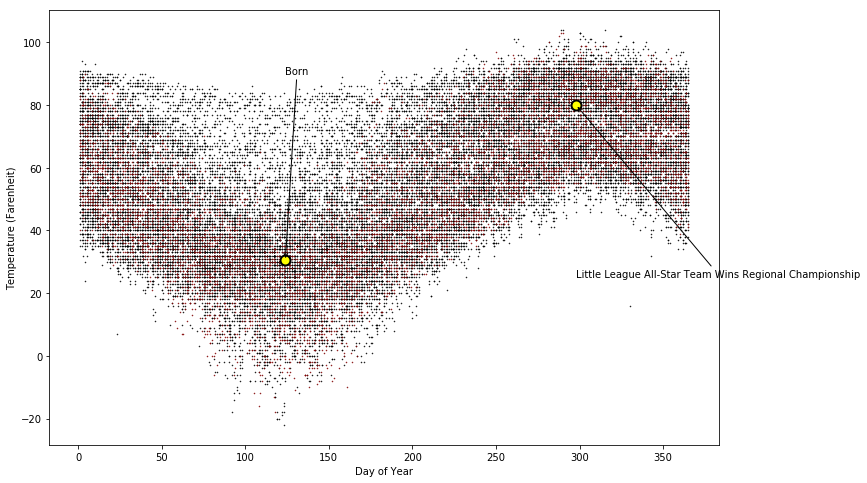

In [3]:
begin = pd.to_datetime('1975-09-21').dayofyear

fig, ax = plt.subplots(figsize=(12,8))
for index, city in enumerate(cities):
    # Convert index to a datetime object
    city.index = pd.to_datetime(city.index)
    # Find the ordinal day of the year
    city['day'] = city.index.dayofyear
    
    city['day'] = np.where(city['day'] >= begin, 
                                     city['day'] - begin + 1, 
                                     366 + city['day'] - begin)
    
    if index == 4:
        plt.scatter(city['day'], city['TMAX'], 
                    c='#800000', linewidths=None, s=1/4)
        plt.scatter(city['day'], city['TMIN'], 
                    c='#800000', linewidths=None, s=1/4)
    else:
        plt.scatter(city['day'], city['TMAX'], 
                    c='black', linewidths=None, s=1/4)
        plt.scatter(city['day'], city['TMIN'], 
                    c='black', linewidths=None, s=1/4)


born = (ind.loc['1975-01-22','TMAX'] + ind.loc['1975-01-22','TMIN']) / 2
league = (pitt.loc['1988-07-14','TMAX'] + pitt.loc['1988-07-14','TMIN']) / 2              
days = 366 + np.array([pd.to_datetime('1975-01-22').dayofyear, 
                       pd.to_datetime('1988-07-14').dayofyear]) - begin

plt.plot(days, [born, league[0]], color='yellow', mec='black', 
         mew=2, marker='o', ms=10, lw=0)           
plt.annotate('Born', xy=(days[0], born), xytext=(days[0], 90), 
                 arrowprops=dict(facecolor='black', arrowstyle='->'))
plt.annotate('Little League All-Star Team Wins Regional Championship', 
             xy=(days[1],league[0]), xytext=(days[1], 25), 
                 arrowprops=dict(facecolor='black', arrowstyle='->'))
              
              
plt.ylabel('Temperature (Farenheit)')
plt.xlabel('Day of Year')
plt.savefig('images/temperature.png', bbox_inches='tight')
plt.show()

**3D Histogram**

In [4]:
lipids  = pd.read_csv('lipids.csv', skiprows=4)
lipids = lipids[lipids.diseased == 1]
lipids.head()

,diseased,chol,trig
51,1,184,145
52,1,263,142
53,1,185,115
54,1,271,128
55,1,173,56


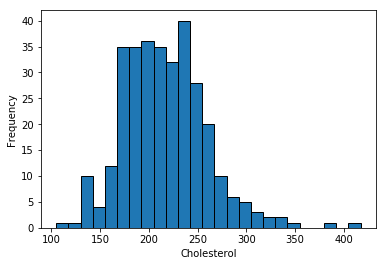

In [5]:
counts, bins, _ = plt.hist(lipids['chol'], bins=25, edgecolor='k')
plt.xlabel('Cholesterol')
plt.ylabel('Frequency')
plt.savefig('images/2D.png')
plt.show()

In [6]:
bins[[counts.argmax(), counts.argmax()+1]].mean()

236.04000000000002

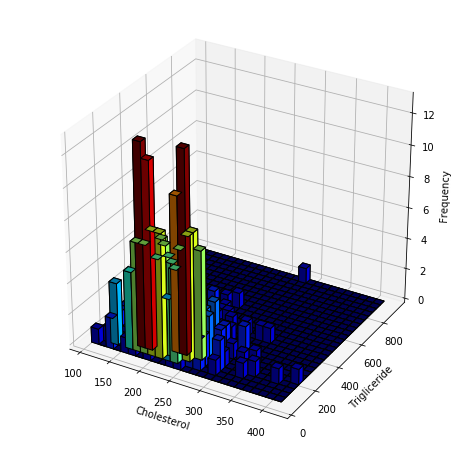

In [7]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

hist, xedges, yedges = np.histogram2d(lipids['chol'], lipids['trig'], bins=25)

xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25)
xpos = xpos.flatten('F')
ypos = ypos.flatten('F')
zpos = np.zeros_like(xpos)

dx = xedges[1] - xedges[0]
dy = yedges[1] - yedges[0]
dz = hist.flatten()

cmap = cm.get_cmap('jet')
max_height = np.max(dz)
min_height = np.min(dz)

rgba = [cmap((k - min_height) / max_height) for k in dz] 

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=rgba, zsort='average', edgecolor='k')
plt.xlabel("Cholesterol")
plt.ylabel("Trigliceride")
ax.set_zlabel('Frequency')
plt.savefig('images/3D.png')

plt.show()

Low trigliceride and low cholesterol seem to be positively correlated.
<br>
The group with the highgest risk for heart disease seems to be those with a trigliceride level of around 200-350 and with a cholesterol level of around 200-250

**Comparing segments of time series**

In [8]:
'''
We need to make some changes to the dates so that everything can run properly
'''

payems = pd.read_csv('payems.csv', index_col=0)
year_change = payems.index.get_loc('1/1/00')  # Century change
pre_payems = payems[:year_change]
post_payems = payems[year_change:]
# We now create some functions to help fix an issue where the centuries get
# mixed up
def f1(s):
    return '19' + s.group(0)
def f2(s):
    return '20' + s.group(0)

pre_payems.index = pre_payems.index.str.replace('(\d\d)$', f1)
post_payems.index = post_payems.index.str.replace('(\d\d)$', f2)
payems = pd.concat([pre_payems, post_payems])
payems.index = pd.to_datetime(payems.index)
payems = payems.resample('MS').ffill()

In [9]:
from fredapi import Fred #pip install fredapi
fred = Fred(api_key='4c746ee107ac3769ff5276c41d811855')

In [10]:
n = 14

indicator = fred.get_series('USREC') # get US recession data

diff = indicator.diff()
peaks = diff[diff == 1][-n:].index

In [11]:
begin = peaks - pd.offsets.DateOffset(years=1)
end = begin + pd.offsets.DateOffset(years=10, months=5) # see part (a)
series1 = []

for i, j in zip(begin, end):
    series1.append(payems[str(i):str(j)])

In [12]:
series2 = []

for i in range(n):
    p = peaks[i]
    norm = series1[i].loc[p]
    norm_series = series1[i] / norm
    
    # Create an index range with 0 at a series value equal to 1
    before = norm_series[:p]
    before.index = range(-len(before)+1, 1)
    after = norm_series[p:]
    after.index = range(1, len(after)+1)
    series2.append(pd.concat([before, after]))

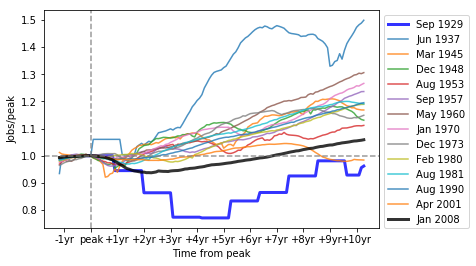

In [13]:
for s, peaks in zip(series2, peaks):
    if peaks.year == 1929:
        plt.plot(s, label=peaks.strftime('%b %Y'), 
                 alpha=0.8, c='b', lw=3)
    elif peaks.year == 2008:
        plt.plot(s, label=peaks.strftime('%b %Y'), 
                 alpha=0.8, c='k', lw=3)
    else:
        plt.plot(s, label=peaks.strftime('%b %Y'), 
                 alpha=0.8)
    
plt.axvline(x=1, c='gray', ls='--', alpha=0.8)
plt.axhline(y=1, c='gray', ls='--', alpha=0.8)
    
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Jobs/peak')
plt.xlabel('Time from peak')
plt.xticks(np.arange(-10, 120, 11), 
           ['-1yr', 'peak', '+1yr', '+2yr', 
            '+3yr', '+4yr', '+5yr', '+6yr', 
            '+7yr', '+8yr', '+9yr', '+10yr'])
plt.savefig('images/job_growth.png')
plt.show()